## Hackathon

In [235]:
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.fft import fft, fftfreq, ifft
from scipy.optimize import curve_fit
from functools import partial

xr.set_options(display_style="text")

## Data loader om data uit de grote set te halen.

Gebruik `loader.get_subset()` voor specifieke ranges van tijd, longitude en latitude. 

Gebruik `subset.to_dataframe()` om een tabel van type xarray om te zetten naar een pandas dataframe. 

In [6]:
class DataLoader:
    """Simple dataloader for NetCDF temperature data."""
    
    def __init__(self, file_path):
        self.file_path = file_path
        self.dataset = None
    
    def load_data(self):
        """Load and preprocess the dataset."""
        self.dataset = xr.open_dataset(self.file_path, engine="h5netcdf")
        
        # Fix coordinates
        if self.dataset["longitude"].max() > 180:
            self.dataset = self.dataset.assign_coords(
                longitude=(self.dataset["longitude"].values + 180) % 360 - 180
            )
        if self.dataset["latitude"].max() > 90:
            self.dataset = self.dataset.assign_coords(
                latitude=self.dataset["latitude"].values - 90
            )
        
        # Sort coordinates
        self.dataset = self.dataset.sortby(["latitude", "longitude"])
        return self.dataset
    
    def get_subset(self, time_range=None, lat_range=None, lon_range=None):
        """Get a subset of the data."""
        if self.dataset is None:
            raise ValueError("Load data first!")
        
        subset = self.dataset
        if time_range:
            subset = subset.sel(valid_time=slice(time_range[0], time_range[1]))
        if lat_range:
            subset = subset.sel(latitude=slice(lat_range[0], lat_range[1]))
        if lon_range:
            subset = subset.sel(longitude=slice(lon_range[0], lon_range[1]))
        
        return subset.compute()
    


In [7]:
# Example usage
loader = DataLoader("2023_2m_temperature.nc")
dataset = loader.load_data()

In [8]:
print(dataset['longitude'].min().item())
print(dataset['longitude'].max().item())
print(dataset['latitude'].min().item())
print(dataset['latitude'].max().item())


-25.0
37.25
34.0
71.25


In [9]:
# Get a subset (May 2023, Europe)
subset = loader.get_subset(
    time_range=("2023-01-01", "2023-12-31"),
    lat_range=(52.25, 52.25),
    lon_range=(5.0, 5.0)
)
subset

min_time = dataset.valid_time.min().values
max_time = dataset.valid_time.max().values

min_lon = dataset.longitude.min().values
max_lon = dataset.longitude.max().values
min_lat = dataset.latitude.min().values
max_lat = dataset.latitude.max().values

print("Min time:", min_time)
print("Max time:", max_time)

print("Min lon:", min_lon)
print("Max lon:", max_lon)
print("Min lat:", min_lat)
print("Max lat:", max_lat)


Min time: 2023-01-01T00:00:00.000000000
Max time: 2023-12-31T23:00:00.000000000
Min lon: -25.0
Max lon: 37.25
Min lat: 34.0
Max lat: 71.25


In [10]:
subset["t2m"].data.flatten()[0:10]

array([287.72104, 287.52673, 287.25696, 286.77545, 285.91565, 285.18488,
       284.83664, 284.40027, 284.11185, 284.33044], dtype=float32)

In [ ]:
subset_df = subset.to_dataframe().reset_index()
subset_df = subset_df.drop(['number', 'expver'], axis=1)
subset.to_dataframe()

mean_t2m = dataset['t2m'].sel(valid_time=slice("2023-05-01", "2023-05-31")).mean(dim='valid_time')

In [ ]:
fig = px.line(subset_df, x='valid_time', y='t2m')
fig.show()    

In [13]:

print(subset_df.columns)

Index(['valid_time', 'latitude', 'longitude', 't2m'], dtype='object')


## Methode om je forecast functie te evalueren op een random steekproef van de dataset. 
In dit voorbeeld wordt steeds 2 weken historische data gepakt en wordt 1 week vooruit voorspeld.

`generate_eval_data()` geeft n random periodes van 3 weken op willekeurige locaties.

`forecast(history, n_points)` neemt een historische reeks van temperaturen en voorspelt de volgende n_points.

`forecast_1w()` evalueert de forecast functie op een random week (MAE score) en toont een grafiek van de historische reeks, de echte waardes en de voorspelde waarde. 

`evaluator(function, n_samples)` berekent de mean absolute error (MAE) van de voorspelling van functie `forecast()` voor een steekproef van grootte n_samples. 

In [127]:
def generate_eval_data(n = 100):
    rng = np.random.default_rng()
    
    # ---- Random geolocation ----
    # Longitude uniform in [-180, 180)
    lon = rng.uniform(-25, 37.25, n)
    lon = np.round(lon * 4)/4
    
    # Latitude area-uniform: sample z = sin(lat) ~ U(-1,1)  => lat = arcsin(z)
    lat = rng.uniform(34, 71.25, n)
    lat = np.round(lat * 4)/4
    
    # ---- Random 3-week interval in 2023 ----
    start0 = pd.Timestamp("2023-01-01")
    # Inclusive end = start + 20 days (21 calendar days total)
    last_start = pd.Timestamp("2023-12-31") - pd.Timedelta(days=20)
    num_choices = (last_start - start0).days + 1
    
    offsets = rng.integers(0, num_choices, n)  # days after Jan 1
    start_date = start0 + pd.to_timedelta(offsets, unit="D")
    end_date = start_date + pd.Timedelta(days=20)
    
    # ---- Assemble DataFrame ----
    df = pd.DataFrame({
        "latitude_deg": lat,
        "longitude_deg": lon,
        "start_date": start_date.strftime("%Y-%m-%d"),
        "end_date": end_date.strftime("%Y-%m-%d")
    })

    return df

In [107]:
def generate_eval_data_non_rand(lon, lat, start_date=['2023-05-01'], end_date=['2023-05-21']):
    # ---- Assemble DataFrame ----
    df = pd.DataFrame({
        "latitude_deg": lat,
        "longitude_deg": lon,
        "start_date": start_date,
        "end_date": end_date
    })
    return df

In [15]:
generate_eval_data(5)

,latitude_deg,longitude_deg,start_date,end_date
0,43.00,-17.50,2023-10-31,2023-11-20
1,37.75,-10.75,2023-03-04,2023-03-24
2,49.75,18.75,2023-06-22,2023-07-12
3,39.00,15.75,2023-02-09,2023-03-01
4,67.50,32.50,2023-01-13,2023-02-02


In [425]:
def sine_model(x, A, b, c, d):
    sin = A * np.sin(2*np.pi/c * (x+b)) + d
    return sin

In [703]:
def AR1(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):
    t = np.arange(len(history))
    guess = [10, 0, 24, np.mean(history)]  
    # limieten: [A1, b1, c1, d1]
    lower = [0, -24, 0, 0]
    upper = [20, 24, 25, 320]

    params, pcov = curve_fit(sine_model, np.arange(len(history)), history, p0=guess, bounds=(lower, upper))
    A, b, c, d= params

    d -= np.mean(history)

    y = sine_model(t, A, b, c, d)

    model = sm.tsa.ARIMA(history, order=(1, 0, 0)).fit()

    forecast = model.forecast(steps=n_points)
    x = np.arange(start=len(history), stop=len(history) + n_points)
    forecast_fitted = forecast + sine_model(x, A, b, c, d)

    return forecast_fitted, forecast

In [491]:
def forecast(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):
    # Take the last point of the history and repeat it n_points times
    try:
        return np.full(n_points, history[-1])
    except: 
        return np.full(n_points, 0)

def forecast_1w(row, function, operation = 'loop'):
    sample = loader.get_subset(
            time_range=(row['start_date'], row['end_date']),
            lat_range=(row['latitude_deg'], row['latitude_deg']),
            lon_range=(row['longitude_deg'], row['longitude_deg'])
        ).compute()
    history = sample.sel(valid_time=slice(row['start_date'],(pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d")))['t2m'].data.flatten()
    y_true = sample.sel(valid_time=slice((pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d"),row['end_date']))['t2m'].data.flatten()
    y_pred_fitted, y_pred = function(history, 
                      row['longitude_deg'], 
                      row['latitude_deg'], 
                      row['start_date'],
                      (pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d"), 
                      len(y_true))
    if operation == 'manual':
        fig, ax = plt.subplots()
        ax.plot(range(len(history)), history, color = 'blue')
        ax.plot(range(len(history), len(history) + len(y_true)), y_true, color = 'blue', linestyle = 'dashed')
        ax.plot(range(len(history), len(history) + len(y_true)), y_pred, color = 'green', linestyle = (0, (1, 1)))
        ax.plot(range(len(history), len(history) + len(y_true)), y_pred_fitted, color = 'red', linestyle = (0, (1, 1)))
    return np.mean(np.abs(y_true - y_pred)), np.mean(np.abs(y_true - y_pred_fitted))

In [18]:
forecast(np.array([9,8,18]), n_points = 5)

array([18, 18, 18, 18, 18])

(1.9599411513073755, 1.481149370000014)

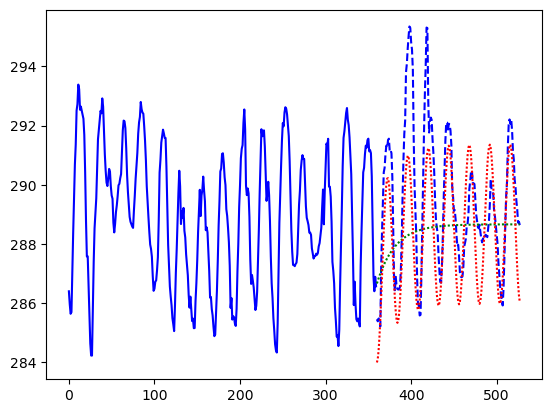

In [704]:
#forecast_1w(generate_eval_data(1).iloc[0], forecast, 'manual')
forecast_1w(generate_eval_data(1).iloc[0], AR1, 'manual')


In [710]:
def evaluator(function, n_samples = 100):
    errors = []
    errors_fitted = []
    df = generate_eval_data(n_samples)
    for index, row in df.iterrows():
        error, error_fitted = forecast_1w(row, function, operation = 'loop')
        errors.append(error)
        errors_fitted.append(error_fitted)
    return np.mean(errors), np.mean(errors_fitted)

In [712]:
evaluator(AR1, 50)

e:\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



(2.001784756526279, 1.7489580987263968)